# Caso grupal: Determinar el alcance espacial por talas y desmontes

|   |     |     |     |     |
|:------|:------|:------|:------|:------|
|   **Asignatura**  | Percepción Computacional|     |     |     |
|   **Grupo**   | 27    |         |   **Integrantes**      | Daniel Díaz Rodríguez  |
|   **Equipo**      | 2 |         |         | Sonia Ortega Martín |
|   **Fecha**       | 03-02-2021 |         |        |   |

La deforestación por las talas y desmontes produce un cambio en la masa forestal. Se plantea determinar el alcance espacial de ese cambio utilizando filtros espaciales y morfológicos.

En la región del Chaco semiárido, Argentina, se concentra el mayor el porcentaje de la deforestación total del país, debido al avance de talas y de desmontes, prohibido por la Ley de Bosques desde 2008. La Corte Suprema Argentina instó a realizar una Evaluación de Impacto Ambiental Acumulativo (EIAAc). Para lo cual se elaboró el informe titulado *Elementos conceptuales y metodológicos para la Evaluación de Impactos Ambientales Acumulativos (EIAAc) en los bosques subtropicales*, cuyo objetivo es poder realizar un seguimiento y mapeo de los desmontes e incendios, a través de tecnología y herramientas informáticas, a fin de alertar sobre el avance de la deforestación. 

Uno de los objetivos que se indica en el informe es determinar el alcance espacial y la dinámica temporal de la afectación por talas y desmontes en el Este de la Provincia de Salta utilizando imágenes satelitales. El equipo de trabajo intentará resolver ese objetivo, utilizando filtros espaciales y morfológicos, identificando las zonas de bosque que han sido reemplazadas.

Para ello utilizamos las observaciones de los satélites *Landsat* tomadas sobre la Provincia de Salta, al norte de Argentina. Imágenes obtenidas de [ciencia.nasa.gov](https://ciencia.nasa.gov/deforestaci%C3%B3n-en-el-gran-chaco-de-argentina). Son dos imágenes sobre la misma zona con una diferencia de dos décadas entre ellas. Aplicaremos filtros para suavizado de imágenes y se pasarán a escala de grises. Se realizará una binarización y se hará la diferencia entre ambas fotos. Se eliminará el posible ruido utilizando filtros morfológicos y se calcularán los bordes de las áreas afectadas. Finalmente se podrá ver sobre las imágenes iniciales el alcance espacial de la deforestación producida. Acceso a [github](https://github.com/sortegamart/Percepcion-Computacional/blob/main/mia03_grupal_Grupo_27_equipo2.ipynb) 

Actualmente existen herramientas tecnológicas para la defensa de los bosques como el [Global Forest Watch (GFW)](https://www.globalforestwatch.org/), que utilizan datos de satélites, machine learning y conocimiento científico para luchar contra la deforestación.

In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

In [2]:
def carga_imagen(ruta_imagen):
    #carga la imagen a partir de la ruta
    img = cv2.imread(ruta_imagen)
    return img
def muestra_imagenes_linea(img1, img2, titulo1, titulo2, tamaño):
    #muestra dos imágenes en línea con sus títulos correspondientes.
    plt.figure(figsize=tamaño)    
    plt.subplot(221), plt.imshow(img1, 'gray')
    plt.title(titulo1), plt.xticks([]), plt.yticks([])
    plt.subplot(222), plt.imshow(img2, 'gray')
    plt.title(titulo2), plt.xticks([]), plt.yticks([])
    plt.show()

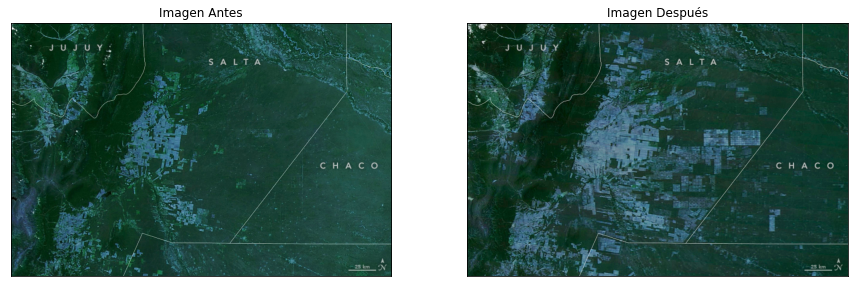

In [3]:
image = carga_imagen('granchaco_2000.jpg') # imagen inicial de Gran Chaco en el año 2.000
back = carga_imagen('granchaco_2019.jpg') # imagen posterior de Gran Chaco en el año 2019
muestra_imagenes_linea(image, back,'Imagen Antes','Imagen Después',(15,12))

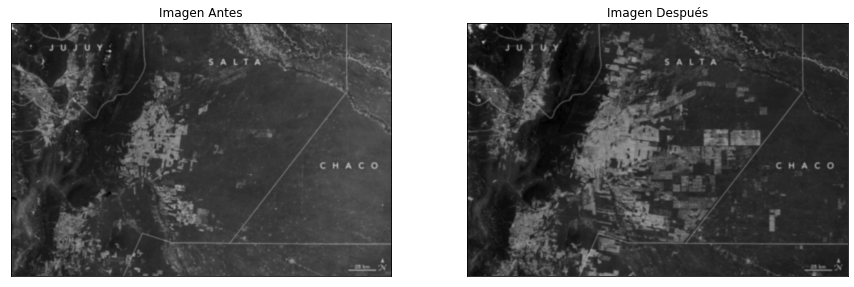

In [4]:
# Aplicamos un filtro Gaussiano para suavizar las imágenes y se pasan a escala de grises
image_blur = cv2.GaussianBlur(image, (51,51), cv2.BORDER_DEFAULT)
image_bw = cv2.cvtColor(image_blur, cv2.COLOR_BGR2GRAY)
back_blur = cv2.GaussianBlur(back, (51,51), cv2.BORDER_DEFAULT)
back_bw = cv2.cvtColor(back_blur, cv2.COLOR_BGR2GRAY)
muestra_imagenes_linea(image_bw, back_bw,'Imagen Antes','Imagen Después',(15,12))

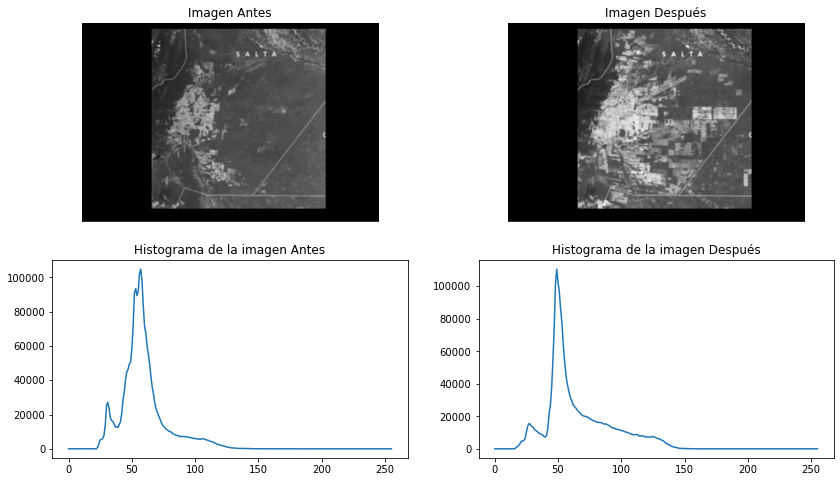

In [5]:
# A través de una máscará identificamos la parte central de las imágenes donde se produce mayor cambio.
mask = np.zeros(image_bw.shape[:2], np.uint8)
mask[50:1600, 600:2100] = 255  # crear máscara central
masked = cv2.bitwise_and(image_bw,image_bw,mask = mask)    # combinación entre la imagen del antes y la máscara
masked_back = cv2.bitwise_and(back_bw,back_bw,mask = mask) # combinación entre la imagen del después y la máscara
# Calculamos el histograma de cada fotografía.
hist_full = cv2.calcHist([image_bw],[0],None,[256],[0,256])     # imagen antes
hist_mask = cv2.calcHist([image_bw],[0],mask,[256],[0,256])     # con máscara 
hist_full_back = cv2.calcHist([back_bw],[0],None,[256],[0,256]) # imagen después
hist_mask_back = cv2.calcHist([back_bw],[0],mask,[256],[0,256]) # con máscara 
# Mostramos resultados     
plt.figure(figsize=(14,8))  
plt.subplot(221), plt.imshow(masked, 'gray')
plt.title('Imagen Antes'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(masked_back, 'gray')
plt.title('Imagen Después'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.plot(hist_mask)
plt.title('Histograma de la imagen Antes')
plt.subplot(224), plt.plot(hist_mask_back)
plt.title('Histograma de la imagen Después')
plt.show()

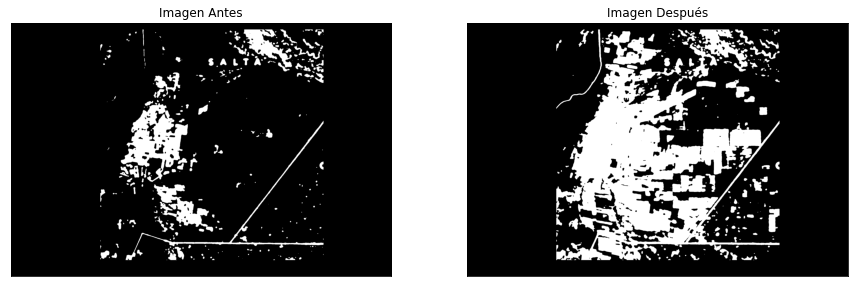

In [6]:
# De los histograma obtenemos los umbrales para cada imagen recortada, y lo aplicamos con threshold para binarizarlo
ret, mascara_image = cv2.threshold(masked, 75, 255, cv2.THRESH_BINARY)
ret, mascara_back = cv2.threshold(masked_back, 60, 255, cv2.THRESH_BINARY)
muestra_imagenes_linea(mascara_image, mascara_back,'Imagen Antes','Imagen Después',(15,12))

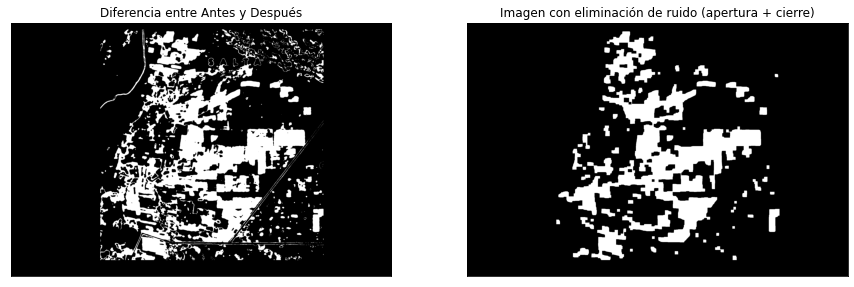

In [7]:
# Hacemos la diferencia entre las imágenes
diff = cv2.absdiff(mascara_image ,mascara_back )
# Eliminación de ruido utilizando filtros morfológicos: apertura seguida de cierre
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17)) # Kernel cuadrado de tamaño 17x17
opening = cv2.morphologyEx(diff, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
muestra_imagenes_linea(diff, closing,'Diferencia entre Antes y Después','Imagen con eliminación de ruido (apertura + cierre)',(15,12))

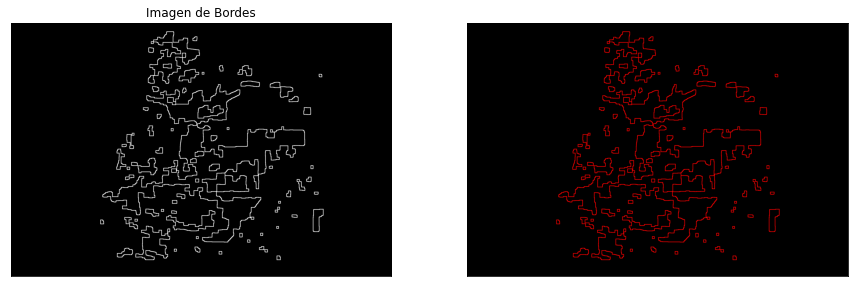

In [8]:
# Calculamos bordes utilizando filtros morfológicos: imagen menos imagen erosionada
kernel_2 = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9)) # Kernel cuadrado de tamaño 9x9
erosion = cv2.erode( closing, kernel_2, iterations = 1)
borde = closing - erosion
# Aplicamos color rojo al borde
red_image = np.zeros(image.shape, np.uint8)
red_image[:, :, 0] = borde
muestra_imagenes_linea(borde, red_image,'Imagen de Bordes','',(15,12))

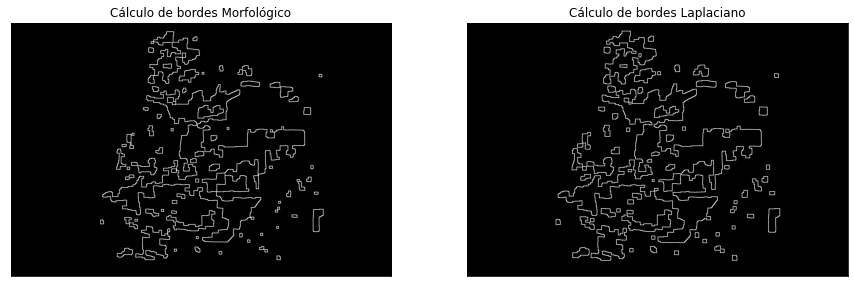

In [9]:
# Cálculo de bordes  aplicando filtros espaciales: filtro Laplaciano
laplacian =cv2.Laplacian(closing,cv2.CV_8U, ksize=9) # Kernel de tamaño 9x9
# Mostramos ambos bordes
muestra_imagenes_linea(borde, laplacian,'Cálculo de bordes Morfológico','Cálculo de bordes Laplaciano',(15,12))

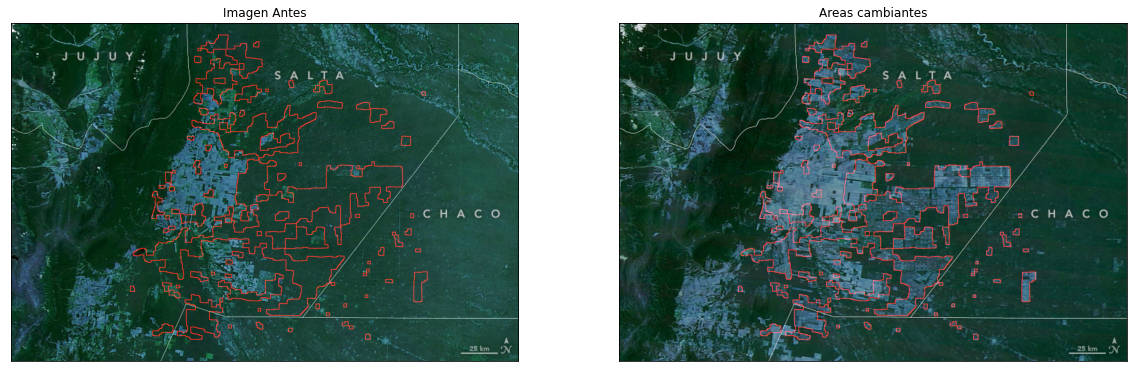

In [10]:
# Restamos el borde a ambas imágenes para poder determinar las áreas cambiantes
imagen_resaltada= cv2.bitwise_or(image,red_image,mask = None)
imagen_resaltada2= cv2.bitwise_or(back,red_image,mask = None)
muestra_imagenes_linea(imagen_resaltada, imagen_resaltada2,'Imagen Antes','Areas cambiantes',(20,15))

Como se puede apreciar se han identificado aquellas zonas donde se ha producido una deforestación a lo largo de las dos décadas.Las zonas delimitadadas por los bordes servirían para medir y determinar la tasa de deforestación.
Tras realizar el análisis se aprecia que un de los mayores inconvenientes para realizar esta técnica es que las imágenes tomadas deben ser muy precisas respecto a la zona a estudiar para que la comparativa sea efectiva. También han sido importantes los ajustes que se han realizado al tomar el umbral y las máscaras de los kernels, realizándose varias pruebas hasta conseguir aquellos que permitieran identificar las zonas a delimitar lo más filemente posible.

Bibliografia:
Leake, Andrés; de Ecónomo, María (2008). La deforestación de Salta. 2004-2007. Salta: Fundación ASOCIANA. ISBN 978-987-24283-0-3. Leake, Andrés; López, Omar Enrique; Leake, María
Cecilia (2016). La deforestación del Chaco Salteño 2004-2015. SMA Ediciones. ISBN 978-987-
45348-4-2.
Agronomía Informa: “La FAUBA analiza el desmonte en Salta”, por exposición del informe
“Evaluación de Impactos Ambientales Acumulativos en el este de Salta”. 24 de septiembre de
2009"

## Información asociada a la actividad conjunta


|   |   Daniel Díaz Rodríguez  |   Sonia Ortega Martín  |
|:------|:------|:------|
|   **Ha participado activamente en el grupo**  | Sí | Sí |
|   **Ha asistido y participado en las reuniones**      | Sí | Sí |
|   **Ha participado en la elaboración de la actividad**       | Sí | Sí |
|   **Ha realizado las tareas asignadas por el equipo**       | Sí | Sí |


Del grupo inicial, nos comunicaron que los dos miembros: Oscar Iglesias Bou y Joseba Barrera Mayo no cursarían esta asignatura este año, por lo que finalmente el grupo lo componemos dos personas:  Daniel Díaz Rodríguez y Sonia Ortega Martín. Ambos hemos participado conjuntamente en la realización de la actividad.